In [6]:
pip install scikit-learn

  Using cached threadpoolctl-3.1.0-py3-none-any.whl (14 kB)
Note: you may need to restart the kernel to use updated packages.


In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math
from Compute_Jacobian import jacobian
import timeit

#from models_tf import Sampler, NN_FF
from matplotlib.animation import FuncAnimation

from sklearn.model_selection import train_test_split
import pandas as pd

In [42]:


class Sampler:
    # Initialize the class
    def __init__(self, dim, coords, func, name = None):
        self.dim = dim
        self.coords = coords
        self.func = func
        self.name = name
    def sample(self, N):
        x = self.coords[0:1,:] + (self.coords[1:2,:]-self.coords[0:1,:])*np.random.rand(N, self.dim)
        y = self.func(x)
        return x, y


class heat1D_ST_FF:
    def __init__(self, layers, operator, e, m, tau, nu, ics_sampler, bcs_sampler, res_sampler,  sigma_wt, sigma_wx, X_star, uv_star):
        X, _ = res_sampler.sample(np.int32(1e5))
        self.mu_X, self.sigma_X = X.mean(0), X.std(0)
        self.mu_t, self.sigma_t = self.mu_X[0], self.sigma_X[0]
        self.mu_x, self.sigma_x = self.mu_X[1], self.sigma_X[1]
        
        # Samplers
#         self.ics_sampler = ics_sampler
#         self.bcs_sampler = bcs_sampler
#         self.res_sampler = res_sampler
        
        # If samplers are lists, unpack them as needed for internal use
#         self.ics_sampler = ics_sampler if isinstance(ics_sampler, list) else [ics_sampler]
#         self.bcs_sampler = bcs_sampler if isinstance(bcs_sampler, list) else [bcs_sampler]
#         self.res_sampler = res_sampler if isinstance(res_sampler, list) else [res_sampler]
        
        self.ics_sampler_v = ics_sampler[0]
        self.ics_sampler_U = ics_sampler[1]
        self.bcs_sampler_U = bcs_sampler[0]
        self.res_sampler = res_sampler

        
        # Define differential operator
        self.e = e
        self.m = m
        self.tau = tau
        self.nu = nu
        self.operator = operator
        
        # Fourier hyperparameter
        self.sigma_wt = sigma_wt
        self.sigma_wx = sigma_wx

        # Initialize spatial and temporal Fourier features
        self.W_t =tf.Variable(tf.random_normal([1, layers[0] //2], dtype=tf.float32)  * sigma_wt, dtype=tf.float32, trainable=False)
        self.W_x = tf.Variable(tf.random_normal([1, layers[0] //2], dtype=tf.float32)  * sigma_wx, dtype=tf.float32, trainable=False)
        
        # Initialize network weights and biases
        self.layers = layers
        self.weights, self.biases = self.initialize_NN(layers)

        # Define Tensorflow session
        self.sess = tf.Session(config=tf.ConfigProto(log_device_placement=True))

        # Define placeholders and computational graph
        self.t_u_tf = tf.placeholder(tf.float32, shape=(None, 1))
        self.x_u_tf = tf.placeholder(tf.float32, shape=(None, 1))

        self.t_ics_tf = tf.placeholder(tf.float32, shape=(None, 1))
        self.x_ics_tf = tf.placeholder(tf.float32, shape=(None, 1))
        self.v_ics_tf = tf.placeholder(tf.float32, shape=(None, 1))
        self.U_ics_tf = tf.placeholder(tf.float32, shape=(None, 1))

        self.t_bc1_tf = tf.placeholder(tf.float32, shape=(None, 1))
        self.x_bc1_tf = tf.placeholder(tf.float32, shape=(None, 1))
        self.U_bc1_tf = tf.placeholder(tf.float32, shape=(None, 1))

#         self.t_bc2_tf = tf.placeholder(tf.float32, shape=(None, 1))
#         self.x_bc2_tf = tf.placeholder(tf.float32, shape=(None, 1))
#         self.u_bc2_tf = tf.placeholder(tf.float32, shape=(None, 1))

        self.t_r_tf = tf.placeholder(tf.float32, shape=(None, 1))
        self.x_r_tf = tf.placeholder(tf.float32, shape=(None, 1))
#         self.r_tf = tf.placeholder(tf.float32, shape=(None, 1))
        
#         # Evaluate predictions
        # Evaluate predictions for `v` and `U`
#         self.v_ics_pred, self.U_ics_pred = self.net_uv(self.t_ics_tf, self.x_ics_tf)
#         self.v_bc1_pred, self.U_bc1_pred = self.net_uv(self.t_bc1_tf, self.x_bc1_tf)
        
#         self.v_pred, self.U_pred = self.net_uv(self.t_u_tf, self.x_u_tf)
#         self.r_v_pred, self.r_U_pred = self.net_r(self.t_r_tf, self.x_r_tf)
        
        # Define variables where we previously had v_ics_pred, U_ics_pred, etc.
        self.v_u_ics_pred = self.net_uv(self.t_ics_tf, self.x_ics_tf)  # Shape (batch_size, 2)
        self.v_u_bc1_pred = self.net_uv(self.t_bc1_tf, self.x_bc1_tf)  # Shape (batch_size, 2)
        self.v_u_pred = self.net_uv(self.t_u_tf, self.x_u_tf)          # Shape (batch_size, 2)

        # In cases where v and U are needed separately, slice them as follows:
        self.v_ics_pred = self.v_u_ics_pred[:, 0:1]  # First column is v
        self.U_ics_pred = self.v_u_ics_pred[:, 1:2]  # Second column is U

#         self.v_bc1_pred = self.v_u_bc1_pred[:, 0:1]
        self.U_bc1_pred = self.v_u_bc1_pred[:, 1:2]

        self.v_pred = self.v_u_pred[:, 0:1]
        self.U_pred = self.v_u_pred[:, 1:2]
        
        self.r_v_pred, self.r_U_pred = self.net_r(self.t_r_tf, self.x_r_tf)

        # Boundary loss and Initial loss
        self.loss_ic_v = tf.reduce_mean(tf.square(self.v_ics_tf - self.v_ics_pred))
        self.loss_ic_U = tf.reduce_mean(tf.square(self.U_ics_tf - self.U_ics_pred))
        self.loss_bc1_U = tf.reduce_mean(tf.square(self.U_bc1_tf - self.U_bc1_pred))
#         self.loss_bc2 = tf.reduce_mean(tf.square(self.u_bc2_pred))

#         self.loss_bcs = self.loss_bc1 + self.loss_bc2
        self.loss_bcs = self.loss_bc1_U
        self.loss_ics =  self.loss_ic_v + self.loss_ic_U
    
        # Residual loss
#         self.loss_res = tf.reduce_mean(tf.square(self.r_pred))
        self.loss_res_v = tf.reduce_mean(tf.square(self.r_v_pred))
        self.loss_res_U = tf.reduce_mean(tf.square(self.r_U_pred))
        self.loss_res = self.loss_res_v + self.loss_res_U
        
        w_res_v = 1
        w_res_U = 1
        w_bcs = 1e2
        w_ics =1
        

        # Total loss
        self.loss = (w_res_v*(self.loss_res_v) + (w_res_U*self.loss_res_U) + (w_bcs*self.loss_bcs) + (w_ics*self.loss_ics))
        
        self.global_step = tf.Variable(0, trainable=False)
        starter_learning_rate = 1e-3
        self.learning_rate = tf.train.exponential_decay(starter_learning_rate, self.global_step,
                                                        1000, 0.9, staircase=False)
        # Passing global_step to minimize() will increment it at each step.
        self.train_op = tf.train.AdamOptimizer(self.learning_rate).minimize(self.loss, global_step=self.global_step)

        # Test data
#         self.X_star = X_star
#         self.u_star = u_star
        
        self.X_star = X_star
        self.v_star = uv_star[:, 0:1]  # Extract `v_star` from `uv_star`
        self.U_star = uv_star[:, 1:2]  # Extract `U_star` from `uv_star`

         # Logger
        self.loss_bcs_log = []
        self.loss_ics_log = []
        self.loss_res_log = []
        self.loss_res_v_log = []
        self.loss_res_U_log = []
        self.total_loss_log = []
        self.l2_error_log = []
        
        # Saver
        self.saver = tf.train.Saver()
        
         # Initialize Tensorflow variables
        init = tf.global_variables_initializer()
        self.sess.run(init)
        
    # Xavier initialization
    def xavier_init(self, size):
        in_dim = size[0]
        out_dim = size[1]
        xavier_stddev = 1. / np.sqrt((in_dim + out_dim) / 2.)
        return tf.Variable(tf.random_normal([in_dim, out_dim], dtype=tf.float32) * xavier_stddev,
                           dtype=tf.float32)

    # Initialize the network
    def initialize_NN(self, layers):
        weights = []
        biases = []
        
        num_layers = len(layers)
        for l in range(0, num_layers - 2):
            W = self.xavier_init(size=[layers[l], layers[l + 1]])
            b = tf.Variable(tf.random_normal([1, layers[l + 1]], dtype=tf.float32), dtype=tf.float32)
            weights.append(W)
            biases.append(b)
        
#        W = self.xavier_init(size=[2 *layers[-2], layers[-1]])
        W = self.xavier_init(size=[layers[-2], layers[-1]])
        b = tf.Variable(tf.random_normal([1, layers[-1]], dtype=tf.float32), dtype=tf.float32)
        weights.append(W)
        biases.append(b)
        
        return weights, biases
        
    # Evaluates the forward pass
    def forward_pass(self, H):
        num_layers = len(self.layers) 
        t = H[:,0:1]
        x = H[:,1:2]

        # Temporal Fourier feature encoding
        H_t = tf.concat([tf.sin(tf.matmul(t, self.W_t)),
                         tf.cos(tf.matmul(t, self.W_t))], 1)   # H1  (N ,50))
        # Spatial Fourier feature encoding
        H_x = tf.concat([tf.sin(tf.matmul(x, self.W_x)),
                         tf.cos(tf.matmul(x, self.W_x))], 1) 

        # Pass through a MLP
        for l in range(0, num_layers-2):
            W = self.weights[l]
            b = self.biases[l]
            H_t = tf.tanh(tf.add(tf.matmul(H_t, W), b))
            H_x = tf.tanh(tf.add(tf.matmul(H_x, W), b))

        # Merge the outputs via point-wise multiplication
        H = tf.multiply(H_t, H_x)   

        W = self.weights[-1]
        b = self.biases[-1]
        H = tf.add(tf.matmul(H, W), b)
        return H
    
     # Forward pass for u
    def net_uv(self, t, x):
#         # Concatenate inputs and pass through forward_pass
#         uv = self.forward_pass(tf.concat([t, x], 1))
#         v = uv[:, 0:1]
#         U = uv[:, 1:2]
#         return v, U
        # Obtain the predicted values for v and U
        v_u = self.forward_pass(tf.concat([t, x], axis=1))  # Concatenate t and x for input
        return v_u  # Returns a tensor where columns are [v, U]
    
     # Forward pass for residual
    def net_r(self, t, x):
        # Pass through the network to get v and U predictions
        v_u = self.net_uv(t, x)
        
        # Compute residuals for both equations using the coupled operator
        residual_v, residual_U = self.operator(v_u, t, x, self.e, self.m, self.tau, self.nu, self.sigma_t, self.sigma_x)
        
        return residual_v, residual_U

    def fetch_minibatch(self, sampler, N):
        X, Y = sampler.sample(N)
        X = (X - self.mu_X) / self.sigma_X
        return X, Y

    def train(self, nIter=10000, batch_size=128):

        start_time = timeit.default_timer()
        for it in range(nIter):
            # Fetch boundary mini-batches
            X_ics_batch, v_ics_batch = self.fetch_minibatch(self.ics_sampler_v, batch_size)
            X_ics_batch, U_ics_batch = self.fetch_minibatch(self.ics_sampler_U, batch_size)
            X_bc1_batch, U_bc1_batch = self.fetch_minibatch(self.bcs_sampler_U, batch_size)
            #X_bc2_batch, u_bc2_batch = self.fetch_minibatch(self.bcs_sampler[1], batch_size)

            # Fetch residual mini-batch
            X_res_batch, _ = self.fetch_minibatch(self.res_sampler, batch_size)

            # Define a dictionary for associating placeholders with data
            tf_dict = {self.t_ics_tf: X_ics_batch[:, 0:1], self.x_ics_tf: X_ics_batch[:, 1:2],
                       self.v_ics_tf: v_ics_batch,
                       self.U_ics_tf: U_ics_batch,
                       self.t_bc1_tf: X_bc1_batch[:, 0:1], self.x_bc1_tf: X_bc1_batch[:, 1:2],
                       self.U_bc1_tf: U_bc1_batch,
                       self.t_r_tf: X_res_batch[:, 0:1], self.x_r_tf: X_res_batch[:, 1:2]}

            # Run the Tensorflow session to minimize the loss
            self.sess.run(self.train_op, tf_dict)

            # Print
            if it % 100 == 0:
                elapsed = timeit.default_timer() - start_time
                loss_value = self.sess.run(self.loss, tf_dict)
                loss_bcs_value, loss_ics_value, loss_res_v_value, loss_res_U_value = self.sess.run([self.loss_bcs, 
                                                                                self.loss_ics, 
                                                                                self.loss_res_v,
                                                                                self.loss_res_U], tf_dict)
    
                v_pred, U_pred = self.predict_v_U(self.X_star)
                error_v = np.linalg.norm(self.v_star - v_pred, 2) / np.linalg.norm(self.v_star, 2)
                error_U = np.linalg.norm(self.U_star - U_pred, 2) / np.linalg.norm(self.U_star, 2)


                self.loss_bcs_log.append(loss_bcs_value)
                self.loss_ics_log.append(loss_ics_value)
                self.loss_res_v_log.append(loss_res_v_value)
                self.loss_res_U_log.append(loss_res_U_value)
                self.total_loss_log.append(loss_value)
#                 self.loss_res_log.append(loss_res_value)
                self.l2_error_log.append((error_v + error_U) / 2)  # Average error
 
                print('It: %d, Loss: %.3e, Loss_bcs: %.3e, Loss_ics: %.3e, Loss_res_v: %.3e, Loss_res_U: %.3e Time: %.2f' %
                      (it, loss_value, loss_bcs_value, loss_ics_value, loss_res_v_value, loss_res_U_value, elapsed))
             
                start_time = timeit.default_timer()

    # Evaluates predictions at test points
    def predict_v_U(self, X_star):
        X_star = (X_star - self.mu_X) / self.sigma_X
        tf_dict = {self.t_u_tf: X_star[:, 0:1], self.x_u_tf: X_star[:, 1:2]}
        v_U_star = self.sess.run([self.v_pred, self.U_pred], tf_dict)
#         v_pred, U_pred = v_U_star[:, 0:1], v_U_star[:, 1:2]
        # Unpack the results directly from v_U_star
        v_pred, U_pred = v_U_star[0], v_U_star[1]
        return v_pred, U_pred

    # Evaluates PDE residual at test points
    def predict_r(self, X_star):
        X_star = (X_star - self.mu_X) / self.sigma_X
        tf_dict = {self.t_r_tf: X_star[:, 0:1], self.x_r_tf: X_star[:, 1:2]}
        r_v_star, r_U_star = self.sess.run([self.r_pred_v, self.r_pred_U], tf_dict)
        return r_v_star, r_U_star

Device mapping:



C:\Users\muhasan\.conda\envs\Mahi\lib\site-packages\ipykernel_launcher.py:286: RuntimeWarning: divide by zero encountered in double_scalars
C:\Users\muhasan\.conda\envs\Mahi\lib\site-packages\ipykernel_launcher.py:287: RuntimeWarning: divide by zero encountered in double_scalars


It: 0, Loss: 5.321e+02, Loss_bcs: 5.213e+00, Loss_ics: 4.600e+00, Loss_res_v: 3.276e+00, Loss_res_U: 2.924e+00 Time: 2.00
It: 100, Loss: 5.364e-01, Loss_bcs: 2.266e-04, Loss_ics: 3.065e-02, Loss_res_v: 2.020e-01, Loss_res_U: 2.811e-01 Time: 6.84
It: 200, Loss: 1.687e-01, Loss_bcs: 7.178e-05, Loss_ics: 4.143e-03, Loss_res_v: 7.783e-02, Loss_res_U: 7.958e-02 Time: 5.26
It: 300, Loss: 1.038e-01, Loss_bcs: 5.579e-05, Loss_ics: 2.528e-03, Loss_res_v: 4.463e-02, Loss_res_U: 5.107e-02 Time: 4.66
It: 400, Loss: 5.918e-02, Loss_bcs: 3.865e-05, Loss_ics: 1.127e-03, Loss_res_v: 2.549e-02, Loss_res_U: 2.871e-02 Time: 4.93
It: 500, Loss: 4.513e-02, Loss_bcs: 3.392e-05, Loss_ics: 8.363e-04, Loss_res_v: 1.631e-02, Loss_res_U: 2.460e-02 Time: 5.41
It: 600, Loss: 3.424e-02, Loss_bcs: 2.732e-05, Loss_ics: 6.002e-04, Loss_res_v: 1.316e-02, Loss_res_U: 1.775e-02 Time: 5.82
It: 700, Loss: 2.311e-02, Loss_bcs: 2.676e-05, Loss_ics: 3.156e-04, Loss_res_v: 1.009e-02, Loss_res_U: 1.003e-02 Time: 6.47
It: 800, L

<IPython.core.display.Javascript object>


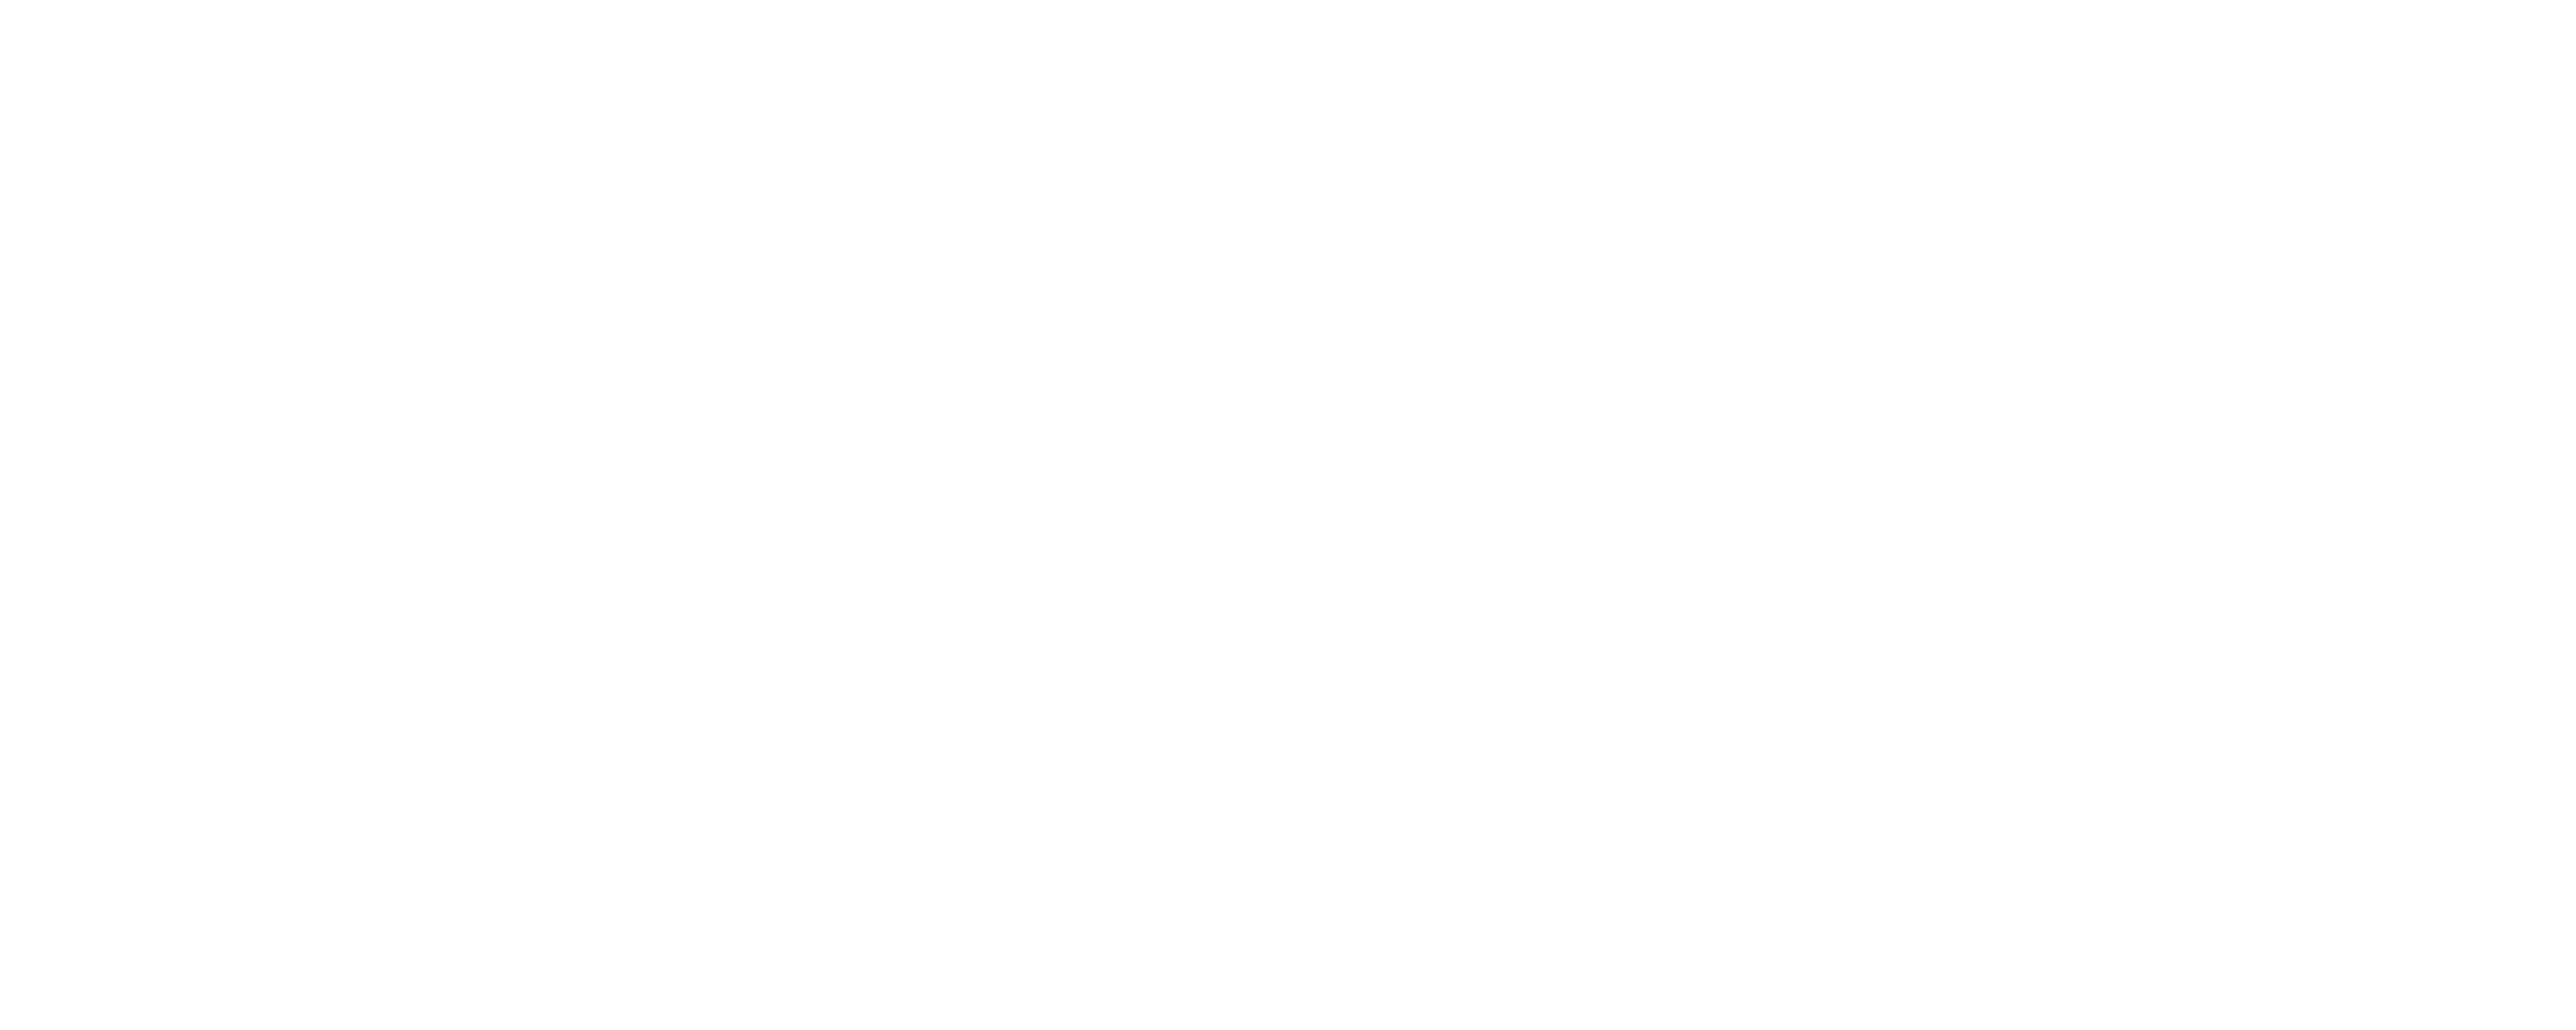

In [43]:
# Define the operators for the coupled equations
def coupled_operator(v_u, t, x, e, m, tau, nu, sigma_t, sigma_x):
    # Extract v and U from the network output
    v, U = v_u[:, 0:1], v_u[:, 1:2]

    # Compute the necessary gradients for v
    v_t = tf.gradients(v, t)[0]
    v_x = tf.gradients(v, x)[0]
    v_xx = tf.gradients(v_x, x)[0]
    U_x = tf.gradients(U, x)[0]

    # Equation 1: ∂v/∂t + v∂v/∂x = -(e/m)∂U/∂x
    residual_v = v_t + v * v_x + (e_scaled / m_scaled) * U_x + (v / tau_scaled) - (nu_scaled * v_xx)

    # Compute the necessary gradients for U
    U_t = tf.gradients(U, t)[0]
#     U_xv = tf.gradients(U * v, x)[0]

    # Equation 2: ∂U/∂t + ∂(Uv)/∂x = 0
    residual_U = U_t + v * U_x + U * v_x

    return residual_v, residual_U

# Parameters
f = 1e12  # Frequency in Hz
num_cycles = 20
T = num_cycles / f
e, m, tau, nu = 1.6e-19, (0.74*9.1e-31), 2e-12, 1e-4  # Charge and mass for the system

# Define scaling factors for the parameters
scale_e = 1e19
scale_m = 1e30
scale_tau = 1e12
scale_nu = 1e4

# Scaled parameters
e_scaled = e * scale_e
m_scaled = m * scale_m
tau_scaled = tau * scale_tau
nu_scaled = nu * scale_nu

x_left, x_right = 0, 100e-9
t_start, t_end = 0, T  # Adjust based on time range

# Define initial and boundary conditions
# def initial_condition_v(x):
#     return np.ones((x.shape[0], 1))

def initial_condition_v(x):
    return np.full((x.shape[0], 1), 0)

# def initial_condition_v(x):
#     return np.sin(2 * np.pi * x[:, 1:2])

def initial_condition_U(x):
    return np.ones((x.shape[0], 1))

def left_boundary_condition_U(t):
    return 1 + 0.01 * np.sin(2 * np.pi * f * t[:, 0:1])

# Define samplers (modify for two outputs)
ics_sampler_v = Sampler(
    dim=2,
    coords=np.array([[t_start, x_left], [t_start, x_right]]),
    func=initial_condition_v
)

ics_sampler_U = Sampler(
    dim=2,
    coords=np.array([[t_start, x_left], [t_start, x_right]]),
    func=initial_condition_U
)

bcs_sampler_U = Sampler(
    dim=2,
    coords=np.array([[t_start, x_left], [t_end, x_left]]),
    func=lambda t: left_boundary_condition_U(t)
)

res_sampler = Sampler(
    dim=2,
    coords=np.array([[t_start, x_left], [t_end, x_right]]),
    func=lambda x: np.zeros((x.shape[0], 2))  # Two zero residuals
)

# Test points
time_values = np.linspace(t_start, t_end, 2000)
spatial_values = np.linspace(x_left, x_right, 1000)
X_star = np.array(np.meshgrid(time_values, spatial_values)).T.reshape(-1, 2)
uv_star=np.zeros((X_star.shape[0], 2))  # Placeholder for coupled outputs

# Modify model initialization for two outputs
layers = [100, 100, 100, 2]  # Last layer has 2 outputs
sigma_wt = 10
sigma_wx = 1

model = heat1D_ST_FF(
    layers=layers,
    operator=coupled_operator,
    e=e_scaled,
    m=m_scaled,
    tau = tau_scaled,
    nu = nu_scaled,
    ics_sampler=[ics_sampler_v, ics_sampler_U],
    bcs_sampler=[bcs_sampler_U],
    res_sampler=res_sampler,
    sigma_wt=sigma_wt,
    sigma_wx=sigma_wx,
    X_star=X_star,
    uv_star=uv_star  # Placeholder for coupled outputs
)

# Train the model
model.train(nIter=10000, batch_size=128)

# Predictions
v_pred, U_pred = model.predict_v_U(X_star)

# v and U predictions need to be interpreted in original units
v_physical = v_pred / scale_nu  # Adjust based on your scaling choice
U_physical = U_pred * (m / e) / scale_e  # Adjust for actual potential interpretation

# Convert x and time to nanometers and picoseconds for the plot
x_in_nm = X_star[:, 1] * 1e9  # Convert x values to nm
t_start_ps = t_start * 1e12  # Convert t_start to ps
t_end_ps = t_end * 1e12  # Convert t_end to ps

# Plotting results
plt.figure(figsize=(15, 6))

# Plot v over space at initial and final time
plt.subplot(1, 2, 1)
plt.plot(x_in_nm[X_star[:, 0] == t_start], v_physical[X_star[:, 0] == t_start], label=f'v at t = {t_start_ps:.2f} ps')
plt.plot(x_in_nm[X_star[:, 0] == t_end], v_physical[X_star[:, 0] == t_end], label=f'v at t = {t_end_ps:.2f} ps')
plt.xlabel('x (nm)')
plt.ylabel('v')
plt.legend()
plt.title("Velocity v over space")

# Plot U over space at initial and final time
plt.subplot(1, 2, 2)
plt.plot(x_in_nm[X_star[:, 0] == t_start], U_physical[X_star[:, 0] == t_start], label=f'U at t = {t_start_ps:.2f} ps')
plt.plot(x_in_nm[X_star[:, 0] == t_end], U_physical[X_star[:, 0] == t_end], label=f'U at t = {t_end_ps:.2f} ps')
plt.xlabel('x (nm)')
plt.ylabel('U (V)')
plt.legend()
plt.title("Potential U over space")

plt.tight_layout()
plt.show()



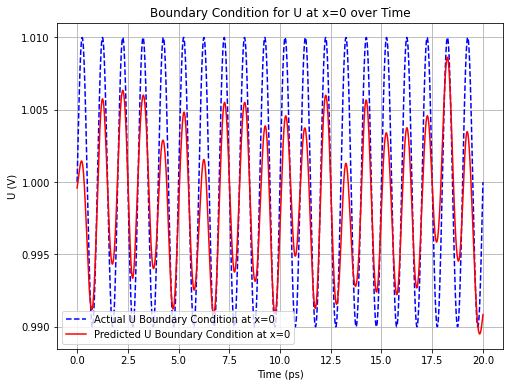

In [46]:
# Define time points for comparison in picoseconds
time_values_ps = time_values * 1e12  # Convert time to picoseconds for plotting

# Actual boundary values from the training data (using left boundary condition function)
U_actual_boundary = left_boundary_condition_U(time_values.reshape(-1, 1))

# Predicted values at x=0 for each time step
X_boundary_star = np.column_stack((time_values, np.zeros_like(time_values)))  # Points at x=0 over time
_, U_pred_boundary = model.predict_v_U(X_boundary_star)

# Plotting actual vs predicted boundary condition for U at x=0
plt.figure(figsize=(8, 6))
plt.plot(time_values_ps, U_actual_boundary, label='Actual U Boundary Condition at x=0', linestyle='--', color='blue')
plt.plot(time_values_ps, U_pred_boundary, label='Predicted U Boundary Condition at x=0', linestyle='-', color='red')
plt.xlabel('Time (ps)')
plt.ylabel('U (V)')
plt.legend()
plt.title("Boundary Condition for U at x=0 over Time")
plt.grid(True)
plt.show()


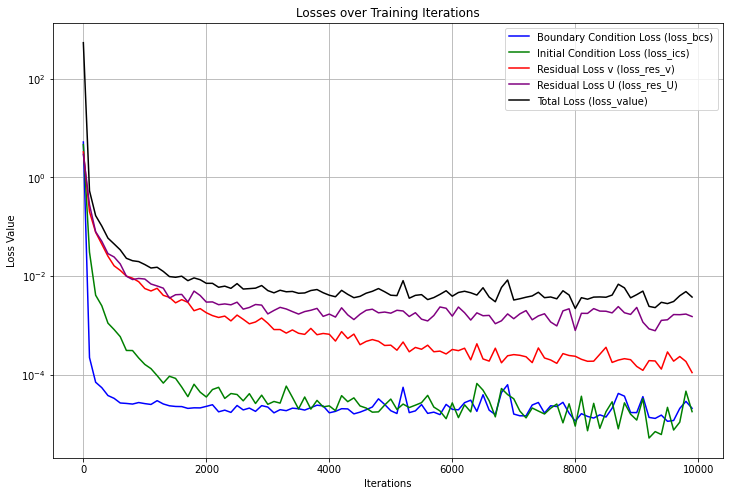

In [45]:
# Assuming training has completed and loss logs are populated

# Plot the individual losses over the training iterations
plt.figure(figsize=(12, 8))

# Generate x-values to represent iteration numbers
iterations = [i * 100 for i in range(len(model.loss_bcs_log))]

# Plot each logged loss component
plt.plot(iterations, model.loss_bcs_log, label='Boundary Condition Loss (loss_bcs)', color='blue')
plt.plot(iterations, model.loss_ics_log, label='Initial Condition Loss (loss_ics)', color='green')
plt.plot(iterations, model.loss_res_v_log, label='Residual Loss v (loss_res_v)', color='red')
plt.plot(iterations, model.loss_res_U_log, label='Residual Loss U (loss_res_U)', color='purple')
plt.plot(iterations, model.total_loss_log, label='Total Loss (loss_value)', color='black')


# Optionally, plot L2 error if needed
# if hasattr(self, 'l2_error_log'):
#     plt.plot(self.l2_error_log, label='L2 Error', color='orange', linestyle='--')

# Labeling the plot
plt.xlabel("Iterations")
plt.ylabel("Loss Value")
plt.yscale("log")  # Optional: Log scale for better visualization of trends
plt.title("Losses over Training Iterations")
plt.legend()
plt.grid(True)
plt.show()

In [44]:
%matplotlib inline

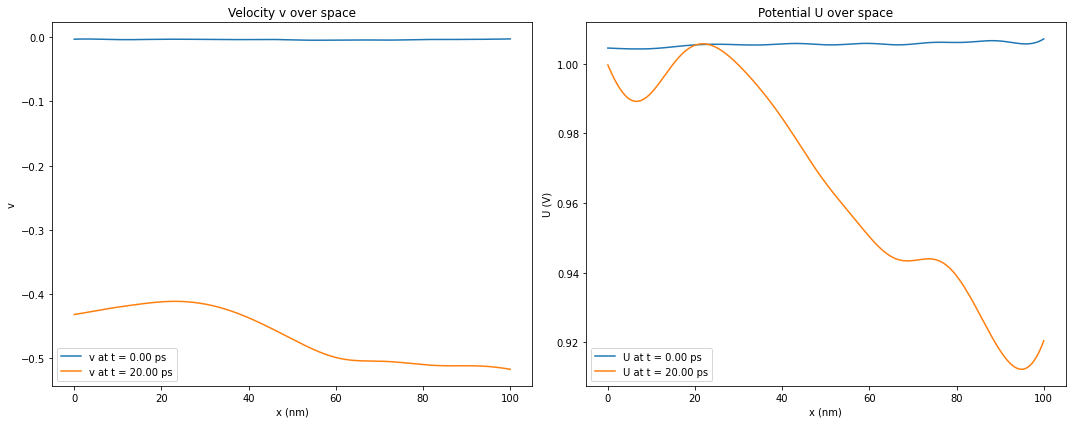

In [11]:
# Convert x and time to nanometers and picoseconds for the plot
x_in_nm = X_star[:, 1] * 1e9  # Convert x values to nm
t_start_ps = t_start * 1e12  # Convert t_start to ps
t_end_ps = t_end * 1e12  # Convert t_end to ps

# Plotting results
plt.figure(figsize=(15, 6))

# Plot v over space at initial and final time
plt.subplot(1, 2, 1)
plt.plot(x_in_nm[X_star[:, 0] == t_start], v_pred[X_star[:, 0] == t_start], label=f'v at t = {t_start_ps:.2f} ps')
plt.plot(x_in_nm[X_star[:, 0] == t_end], v_pred[X_star[:, 0] == t_end], label=f'v at t = {t_end_ps:.2f} ps')
plt.xlabel('x (nm)')
plt.ylabel('v')
plt.legend()
plt.title("Velocity v over space")

# Plot U over space at initial and final time
plt.subplot(1, 2, 2)
plt.plot(x_in_nm[X_star[:, 0] == t_start], U_pred[X_star[:, 0] == t_start], label=f'U at t = {t_start_ps:.2f} ps')
plt.plot(x_in_nm[X_star[:, 0] == t_end], U_pred[X_star[:, 0] == t_end], label=f'U at t = {t_end_ps:.2f} ps')
plt.xlabel('x (nm)')
plt.ylabel('U (V)')
plt.legend()
plt.title("Potential U over space")

plt.tight_layout()
plt.show()




In [47]:
%matplotlib notebook

<IPython.core.display.Javascript object>


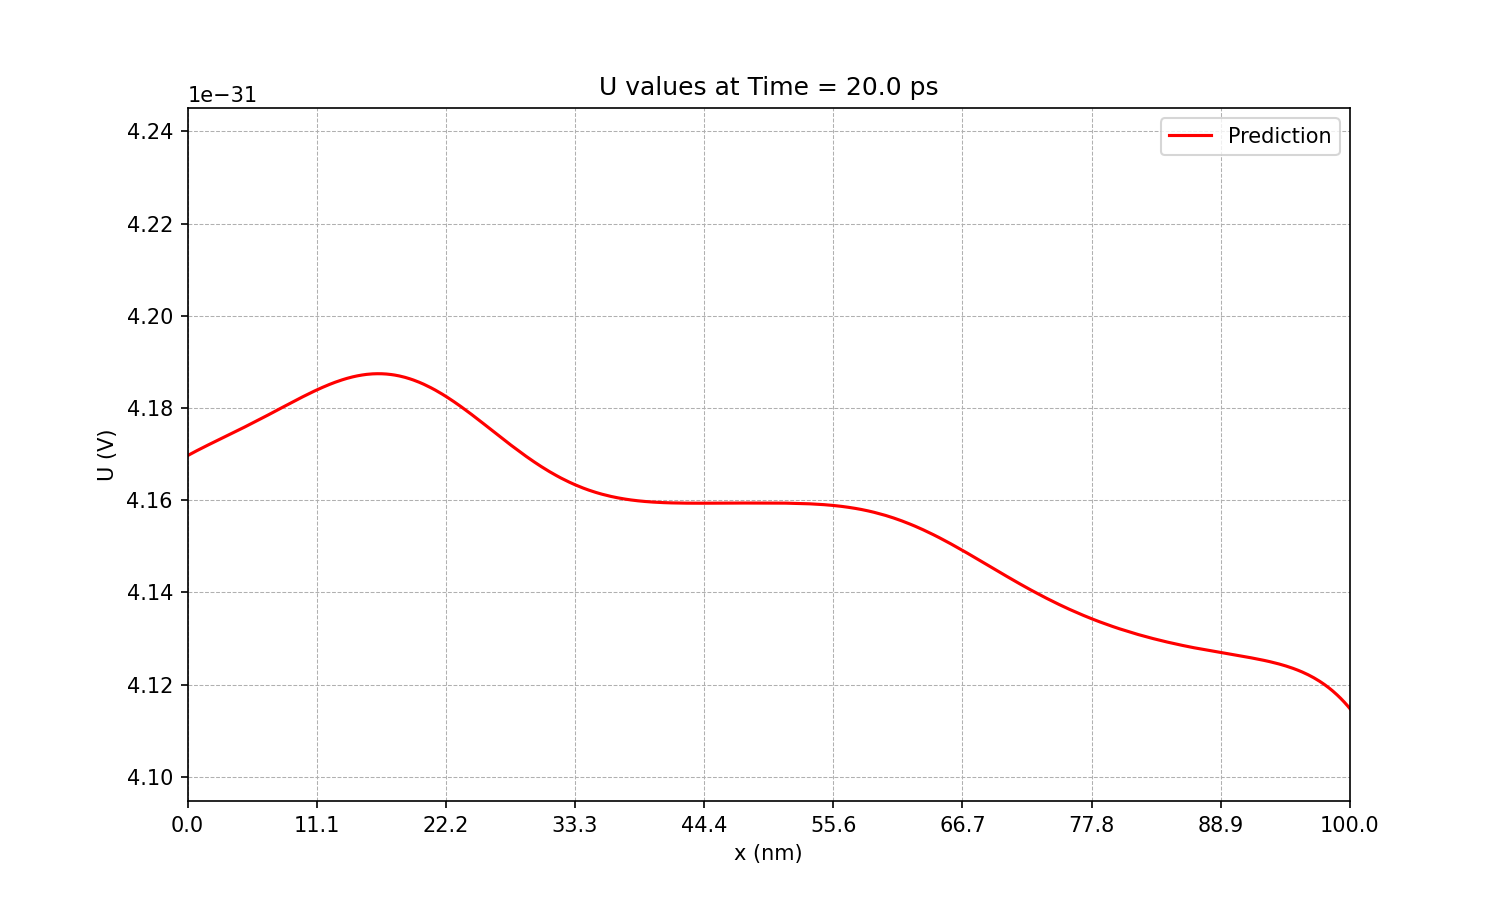

In [48]:
# Set the random seed for reproducibility, if desired
np.random.seed(42)
num_intermediate_steps = 500
unique_times = np.unique(X_star[:, 0]) 
# Randomly select unique time steps from X_star and sort them
selected_times = np.sort(np.random.choice(unique_times, num_intermediate_steps, replace=False))

# Set up the figure and axis for the animation
fig, ax = plt.subplots(figsize=(10, 6))
line, = ax.plot([], [], 'r-', label='Prediction')
ax.set_xlabel('x (nm)')
ax.set_ylabel('U (V)')
ax.legend()
ax.grid(True, which='both', linestyle='--', linewidth=0.5)

# Define x-axis ticks in nanometers (nm)
x_ticks = np.linspace(np.min(X_star[:, 1]) * 1e9, np.max(X_star[:, 1]) * 1e9, num=10)
ax.set_xticks(x_ticks)

# Initialization function to set limits and empty data
def init():
    ax.set_xlim(np.min(X_star[:, 1]) * 1e9, np.max(X_star[:, 1]) * 1e9)  # Convert to nm
    ax.set_ylim(np.min(U_physical), np.max(U_physical))
    line.set_data([], [])
    return line,

# Update function for each frame in the animation
def update(frame):
    time = selected_times[frame]
    time_indices = np.where(X_star[:, 0] == time)[0]

    if np.any(time_indices):  # Check if any indices were found
        U_at_time = U_physical[time_indices]  # Get U values
        x_at_time = X_star[time_indices, 1] * 1e9  # Convert x values to nm
        line.set_data(x_at_time, U_at_time)
        ax.set_title(f'U values at Time = {time * 1e12:.3} ps')
    return line,

# Create the animation
anim_U = FuncAnimation(
    fig, update, frames=len(selected_times), init_func=init, blit=True, repeat=False
)

plt.show()
# Uncomment below to save as a .mp4 or .gif file
# anim.save('U_values_animation.mp4', writer='ffmpeg')


In [62]:
anim_U.save('u_values_animation.gif', writer='pillow', fps=10)

In [59]:
from matplotlib.animation import PillowWriter

# Save the animation with a loop setting in metadata
pillow_writer = PillowWriter(fps=10)
anim.save('u_values_animation.gif', writer=pillow_writer, savefig_kwargs={'loop': 0})

C:\Users\muhasan\.conda\envs\Mahi\lib\site-packages\ipykernel_launcher.py:5: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "loop" which is no longer supported as of 3.3 and will become an error two minor releases later
  """


<IPython.core.display.Javascript object>


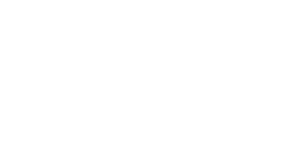

<IPython.core.display.Javascript object>


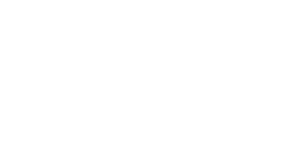

In [19]:
# Set the random seed for reproducibility, if desired
np.random.seed(42)
num_intermediate_steps = 500
unique_times = np.unique(X_star[:, 0]) 
# Randomly select unique time steps from X_star and sort them
selected_times = np.sort(np.random.choice(unique_times, num_intermediate_steps, replace=False))

# Set up the figure and axis for the animation
fig, ax = plt.subplots(figsize=(10, 6))
line, = ax.plot([], [], 'r-', label='Prediction')
ax.set_xlabel('x (nm)')
ax.set_ylabel('v')
ax.legend()
ax.grid(True, which='both', linestyle='--', linewidth=0.5)

# Define x-axis ticks in nanometers (nm)
x_ticks = np.linspace(np.min(X_star[:, 1]) * 1e9, np.max(X_star[:, 1]) * 1e9, num=10)
ax.set_xticks(x_ticks)

# Initialization function to set limits and empty data
def init():
    ax.set_xlim(np.min(X_star[:, 1]) * 1e9, np.max(X_star[:, 1]) * 1e9)  # Convert to nm
    ax.set_ylim(np.min(v_pred), np.max(v_pred))
    line.set_data([], [])
    return line,

# Update function for each frame in the animation
def update(frame):
    time = selected_times[frame]
    time_indices = np.where(X_star[:, 0] == time)[0]

    if np.any(time_indices):  # Check if any indices were found
        v_at_time = v_pred[time_indices]  # Get U values
        x_at_time = X_star[time_indices, 1] * 1e9  # Convert x values to nm
        line.set_data(x_at_time, v_at_time)
        ax.set_title(f'v values at Time = {time * 1e12:.3} ps')
    return line,

# Create the animation
anim_v = FuncAnimation(
    fig, update, frames=len(selected_times), init_func=init, blit=True, repeat=False
)

plt.show()
# Uncomment below to save as a .mp4 or .gif file
# anim.save('U_values_animation.mp4', writer='ffmpeg')


In [ ]:
anim_v.save('v_values_animation.gif', writer='pillow', fps=10)